In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

# Load income per capita as response variable
# http://www.technologyforge.net/Datasets/
data = pd.read_csv('DiabetesDiagnosis.csv', low_memory=False)
data.head()

,Pregnancies,PG Concentration,Diastolic BP,Tri Fold Thick,Serum Ins,BMI,DP Function,Age,Diagnosis
0,6,148,72,35,0,33.6,0.627,50,Sick
1,1,85,66,29,0,26.6,0.351,31,Healthy
2,8,183,64,0,0,23.3,0.672,32,Sick
3,1,89,66,23,94,28.1,0.167,21,Healthy
4,0,137,40,35,168,43.1,2.288,33,Sick


In [2]:
predictors = data[['Pregnancies','PG Concentration', 'Diastolic BP',
                   'Tri Fold Thick', 'Serum Ins', 'BMI', 'DP Function',
                   'Age']]
from sklearn import preprocessing
explanatory_vars = DataFrame()
explanatory_vars['Pregnancies']=preprocessing.scale(predictors['Pregnancies'].astype('float64'))
explanatory_vars['PG Concentration']=preprocessing.scale(predictors['PG Concentration'].astype('float64'))
explanatory_vars['Diastolic BP']=preprocessing.scale(predictors['Diastolic BP'].astype('float64'))
explanatory_vars['Tri Fold Thick']=preprocessing.scale(predictors['Tri Fold Thick'].astype('float64'))
explanatory_vars['Serum Ins']=preprocessing.scale(predictors['Serum Ins'].astype('float64'))
explanatory_vars['BMI']=preprocessing.scale(predictors['BMI'].astype('float64'))
explanatory_vars['DP Function']=preprocessing.scale(predictors['DP Function'].astype('float64'))
explanatory_vars['Age']=preprocessing.scale(predictors['Age'].astype('float64'))

from sklearn.cross_validation import train_test_split
# split data into train and test sets
expla_train, expla_test = train_test_split(explanatory_vars, test_size=.3, random_state=123)

print('Training set: {0}. Testing set: {1}'.format(expla_train.shape, expla_test.shape) )

Training set: (537, 8). Testing set: (231, 8)


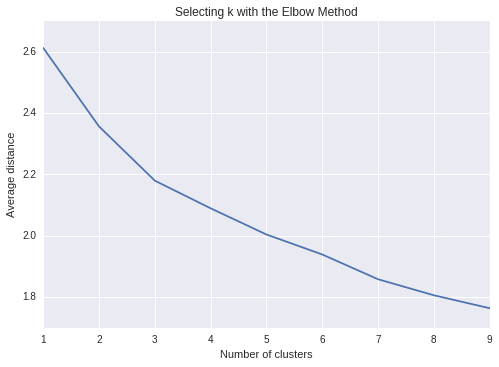

In [3]:
# k-means cluster analysis for 1-9 clusters
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(expla_train)
    clusassign=model.predict(expla_train)
    meandist.append(sum(np.min(cdist(expla_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / expla_train.shape[0])

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

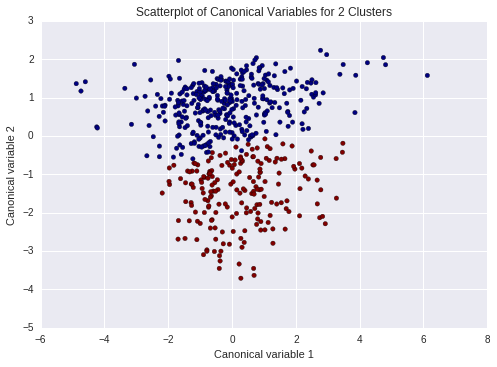

In [4]:
# Interpret 2 cluster solution
model3=KMeans(n_clusters=2)
model3.fit(expla_train)
clusassign=model3.predict(expla_train)

# plot clusters, using top two variables
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(expla_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_, cmap='jet')
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

In [5]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
expla_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(expla_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(expla_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

0    343
1    194
Name: cluster, dtype: int64

In [6]:
"""
END multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print("Clustering variable means by cluster")
clustergrp

Clustering variable means by cluster


,index,Pregnancies,PG Concentration,Diastolic BP,Tri Fold Thick,Serum Ins,BMI,DP Function,Age
cluster,,,,,,,,,
0,400.466472,-0.521945,-0.201636,-0.222040,0.125272,0.103708,-0.029622,-0.009259,-0.587335
1,365.149485,0.894053,0.308206,0.412926,-0.192735,-0.131412,0.087234,-0.057429,1.062837


In [7]:
# validate clusters in training data by examining cluster differences in Diagnosis using ANOVA

diagnosis = data['Diagnosis'].map({'Healthy': 1, 'Sick': 0})
# split poll data into train and test sets
poll_train, poll_test = train_test_split(diagnosis, test_size=.3, random_state=123)
poll_train1=pd.DataFrame(poll_train)
poll_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(poll_train1, merged_train, on='index')
sub1 = merged_train_all[['Diagnosis', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

poll_mod = smf.ols(formula='Diagnosis ~ C(cluster)', data=sub1).fit()
print (poll_mod.summary())

                            OLS Regression Results                            
Dep. Variable:              Diagnosis   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     34.50
Date:                Thu, 25 Aug 2016   Prob (F-statistic):           7.49e-09
Time:                        07:30:20   Log-Likelihood:                -342.09
No. Observations:                 537   AIC:                             688.2
Df Residuals:                     535   BIC:                             696.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.7522      0.025     

In [8]:
print ('means for Diagnosis by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('standard deviations for Diagnosis by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

import sklearn.metrics
predictions = model3.predict(expla_test)
sklearn.metrics.accuracy_score(poll_test, predictions)

means for Diagnosis by cluster
         Diagnosis
cluster           
0         0.752187
1         0.510309
standard deviations for Diagnosis by cluster
         Diagnosis
cluster           
0         0.432374
1         0.501187


0.31168831168831168

**only two categories, no need to perform post hoc test
code below is for reference only**

>mc1 = multi.MultiComparison(sub1['Diagnosis'], sub1['cluster'])
>res1 = mc1.tukeyhsd()
>print(res1.summary())